In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from nicks_plot_utils import *
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import quad, tplquad

from maid_interface import maid_2007_Npi  as maid
# from maid_interface_old import maid_Npi  as maid_old

In [2]:
w_bins = np.array([1.2, 1.22, 1.24, 1.26, 1.28, 1.3,
                   1.32, 1.34, 1.36, 1.38, 1.4, 1.42, 1.44, 1.46, 1.48, 1.5, 1.52,
                   1.54, 1.56, 1.58, 1.6, 1.62, 1.64, 1.66, 1.68, 1.7, 1.72, 1.74,
                   1.76, 1.78, 1.8])


q2_bins = np.array([1.1, 1.33, 1.56, 1.87, 2.23, 2.66, 3.5])

theta_bins = np.array([-1.0, -0.8, -0.6, -0.4, -0.2,
                       0.0, 0.2, 0.4, 0.6, 0.8])




phi_binning = 10

In [3]:
def get_maid_values(xs, w, q2, theta):
    ENERGY = 4.81726
    crossSections = []
    for phi in xs:
        crossSections.append(maid(ENERGY, w, q2, theta, np.degrees(phi)))
        
    return np.array(crossSections)


def maid_values(phi, w, q2, theta):
    ENERGY = 4.81726        
    return maid(ENERGY, w, q2, theta, np.degrees(phi))

def plot_maid_model(ax, w, q2, theta, xs, fmt='.'):
    # Get bin centers
    #_w = (w.left + w.right) / 2.0
    #_q2 = (q2.left + q2.right) / 2.0
    #_theta = (theta.left + theta.right) / 2.0
    # Get the cross section values from maid
    crossSections = get_maid_values(xs, w, q2, theta)
    # _ax = ax.twinx()
    ax.errorbar(xs, crossSections, fmt=fmt, alpha=0.8, ms=15)
    # ax.set_ylim(bottom=0, top=np.max(crossSections)*1.5)

    return np.array(crossSections)


def binCetnerCorrection(w, q2, theta, num_bins=10):
    # Get bin centers
    _w = (w.left + w.right) / 2.0
    _q2 = (q2.left + q2.right) / 2.0
    _theta = (theta.left + theta.right) / 2.0
    # make a huge space of phis
    width = np.linspace(0,  2*np.pi, num_bins, endpoint=True)[1]
    left = np.array([i*width for i in range(num_bins+2)])
    right = np.array([(i-1)*width for i in range(num_bins+2)])

    center = (left+right)/2.0
    ys = []
    for _w_ in [w.left, w.right]:
        for _q2_ in [q2.left, q2.right]:
            for _theta_ in [theta.left+0.001, theta.right-0.001]:
                for xs in [left, right]:
                    # Get the cross section values from maid
                    crossSections = get_maid_values(xs, _w_, _q2_, _theta_)
                    ys.append(crossSections)

    crossSections_center = get_maid_values(xs, _w, _q2, _theta)
    avg = np.sum(ys, axis=0)/16

    bin_center_corr = interp1d(center, avg/crossSections_center, kind='cubic')
    return bin_center_corr




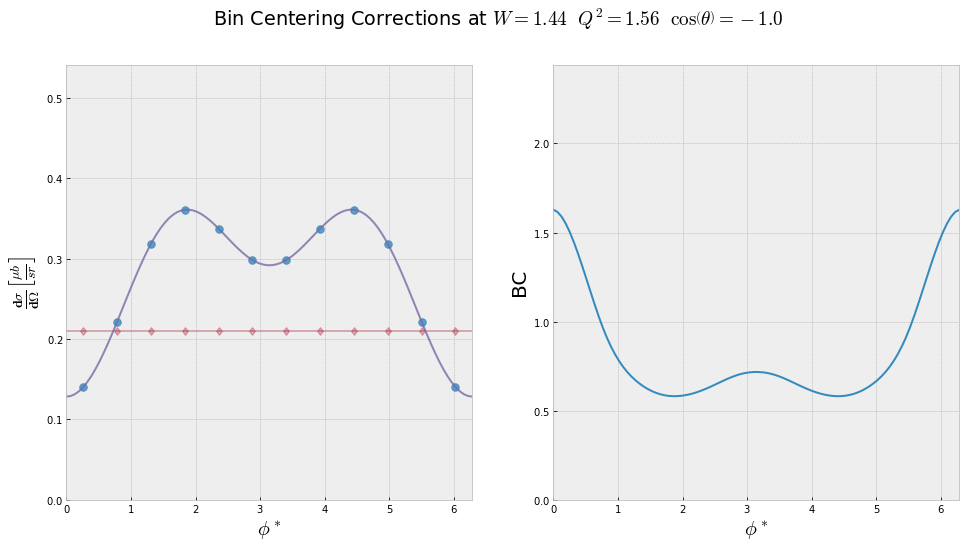

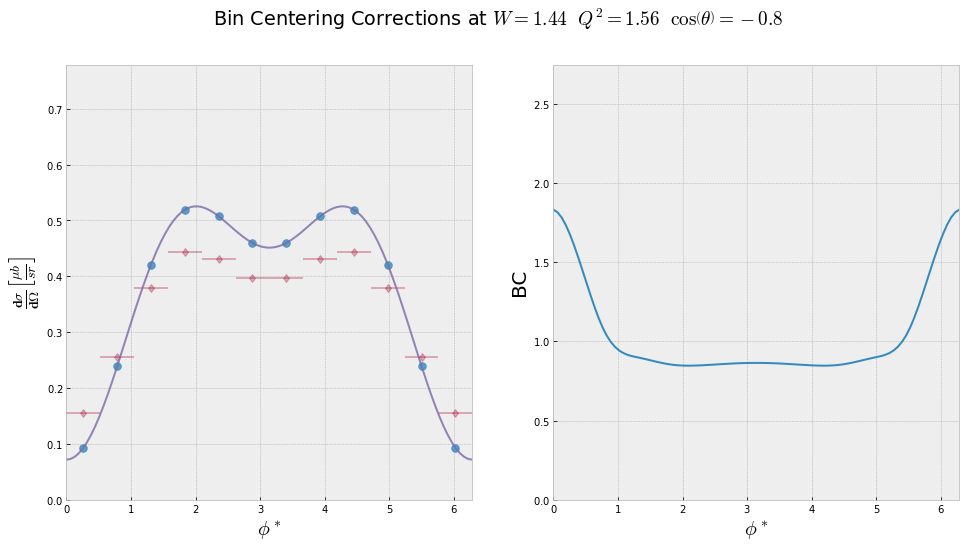

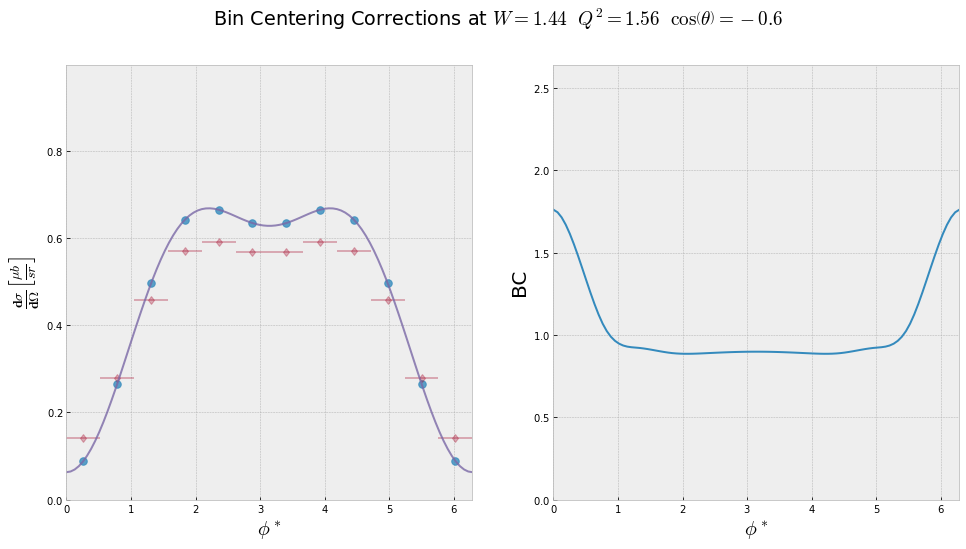

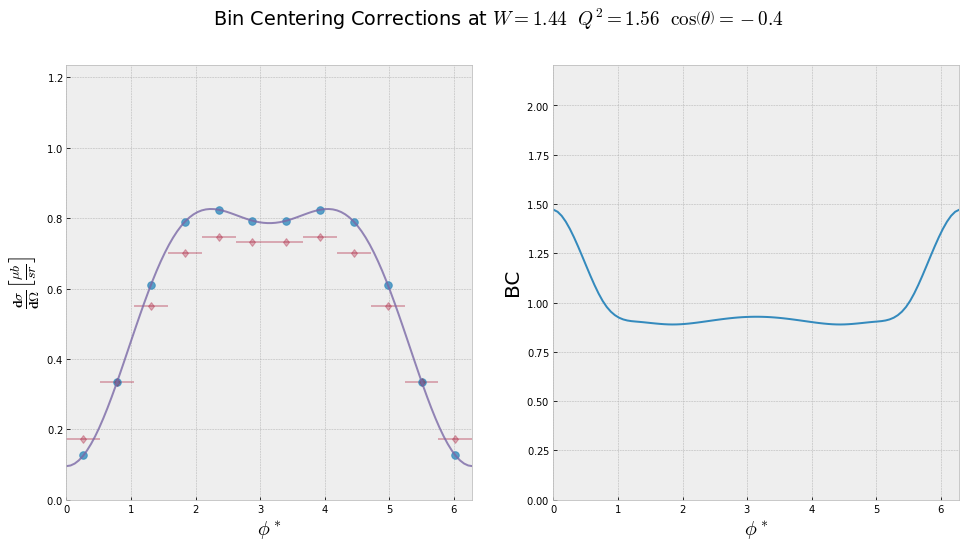

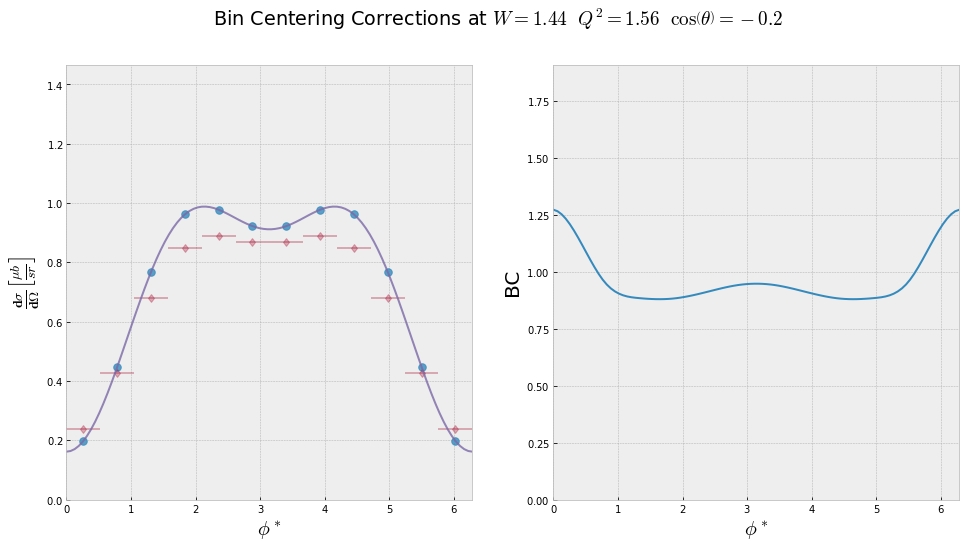

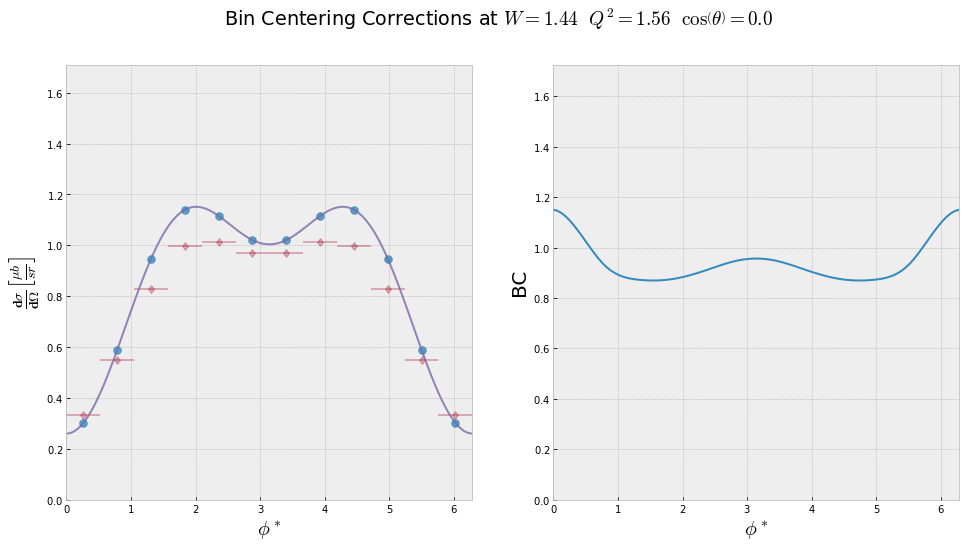

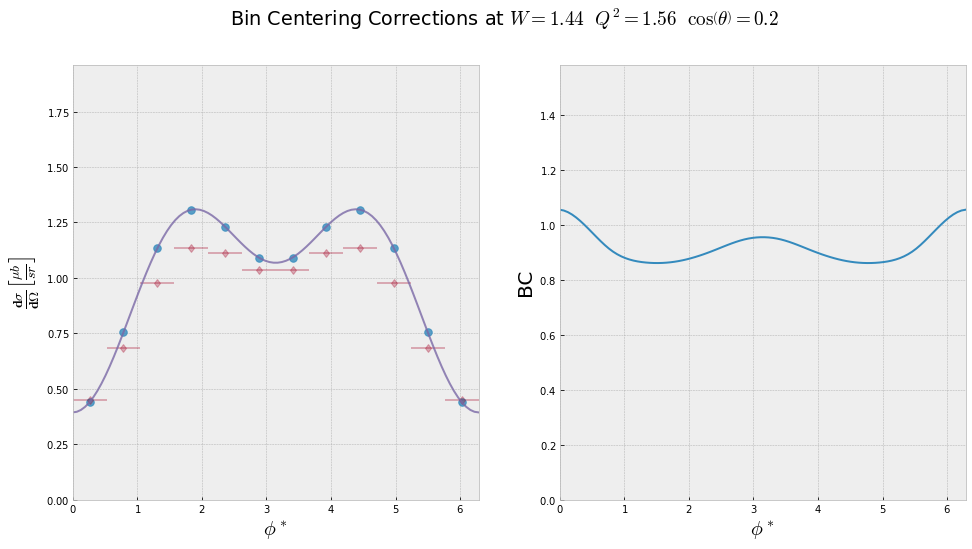

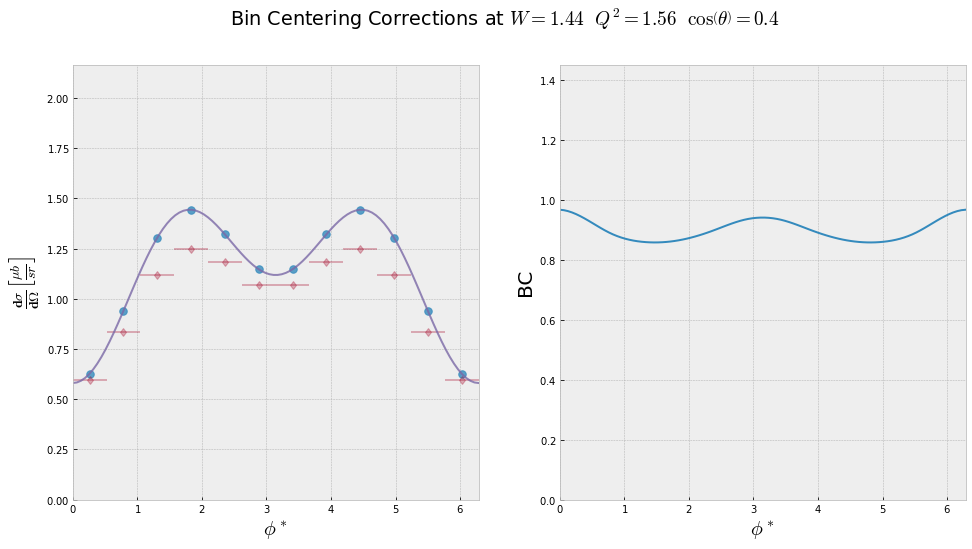

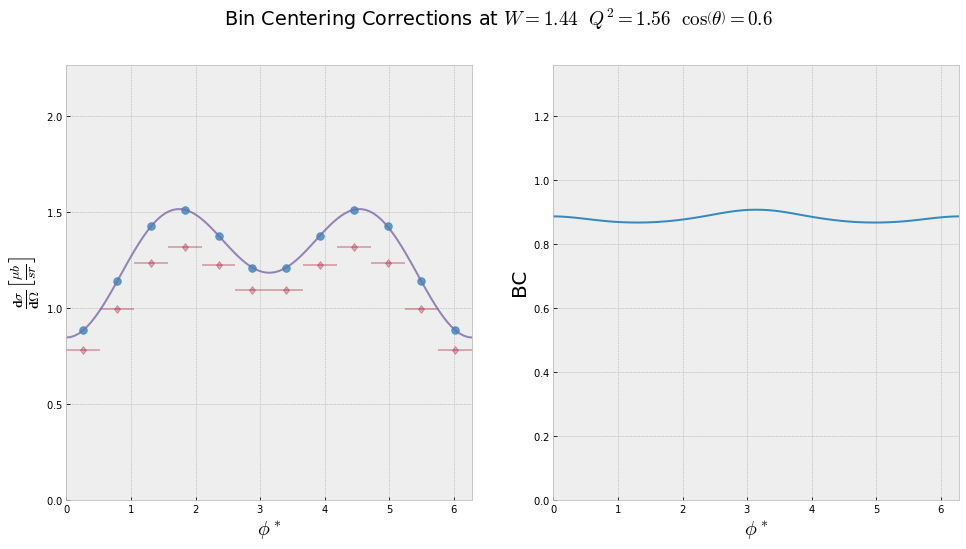

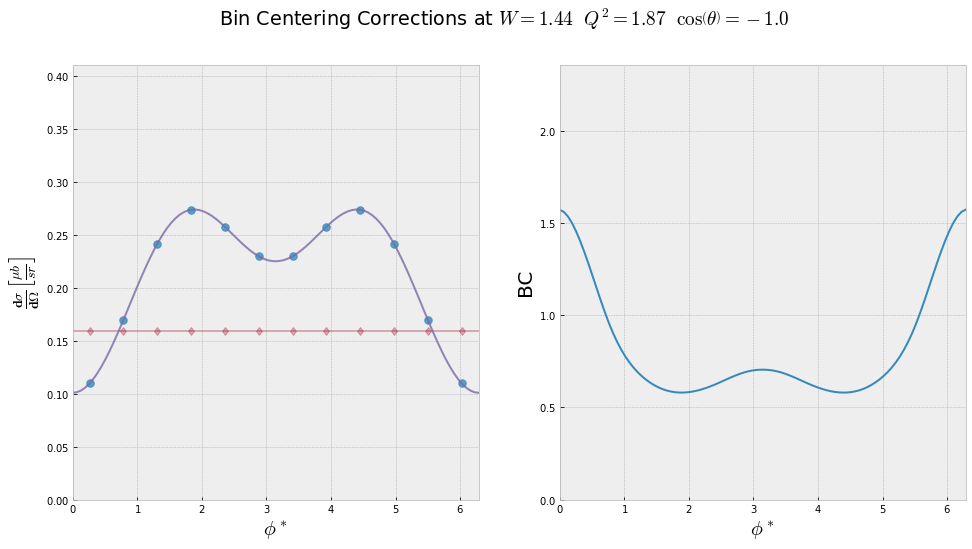

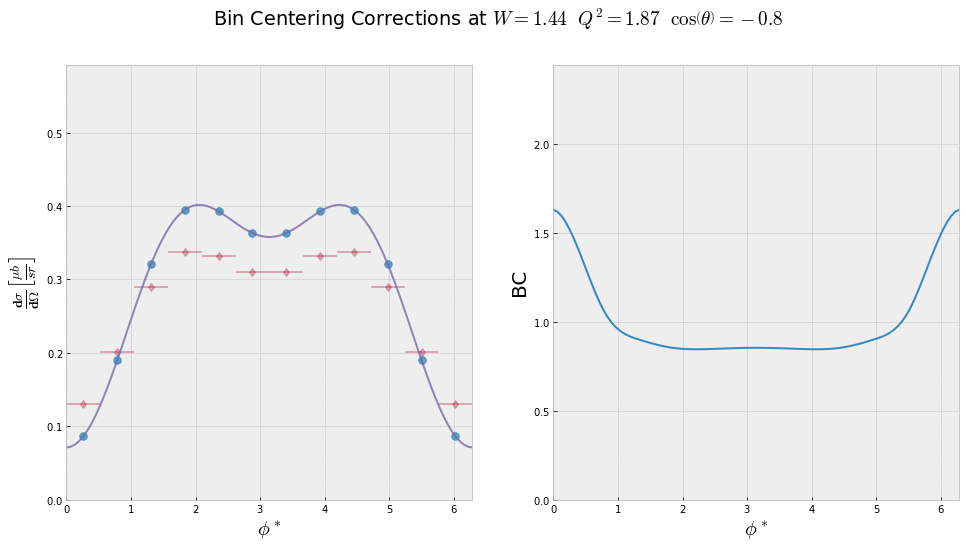

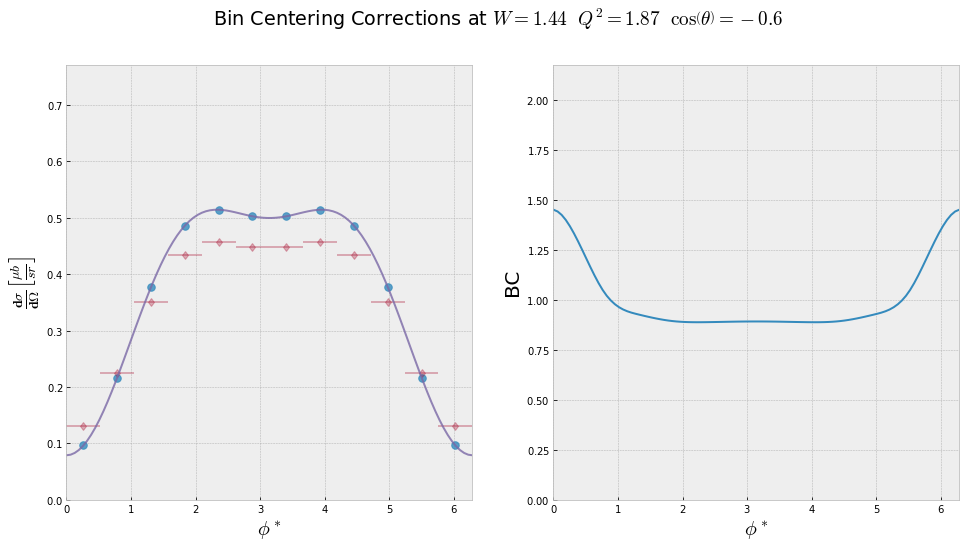

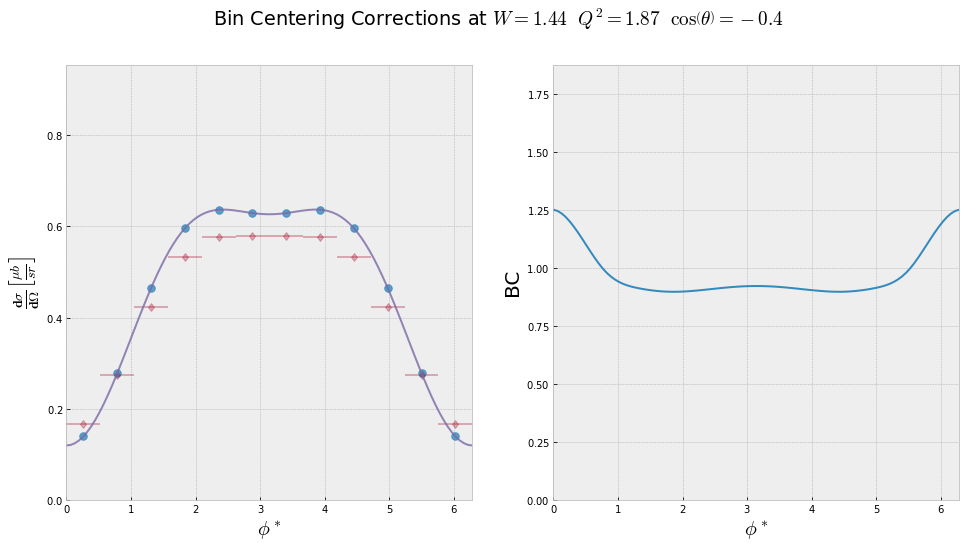

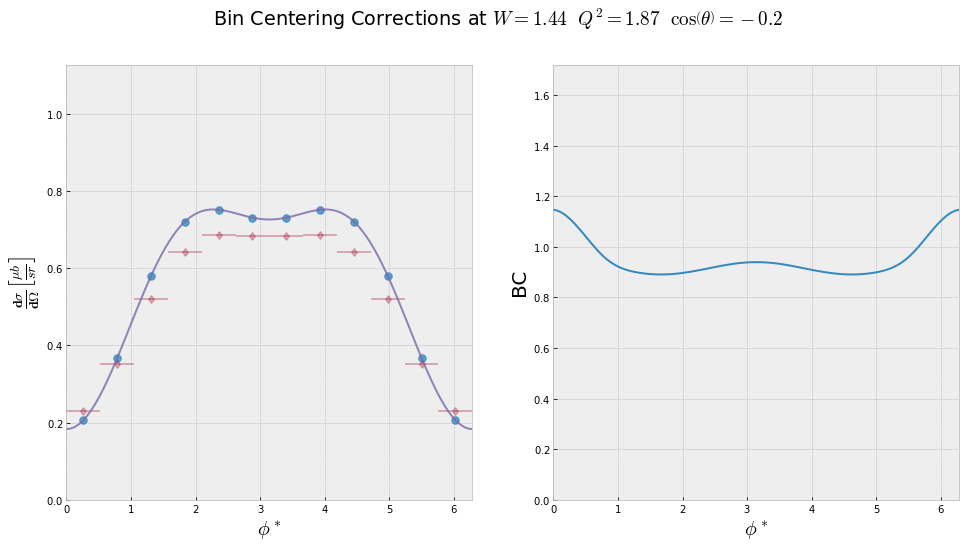

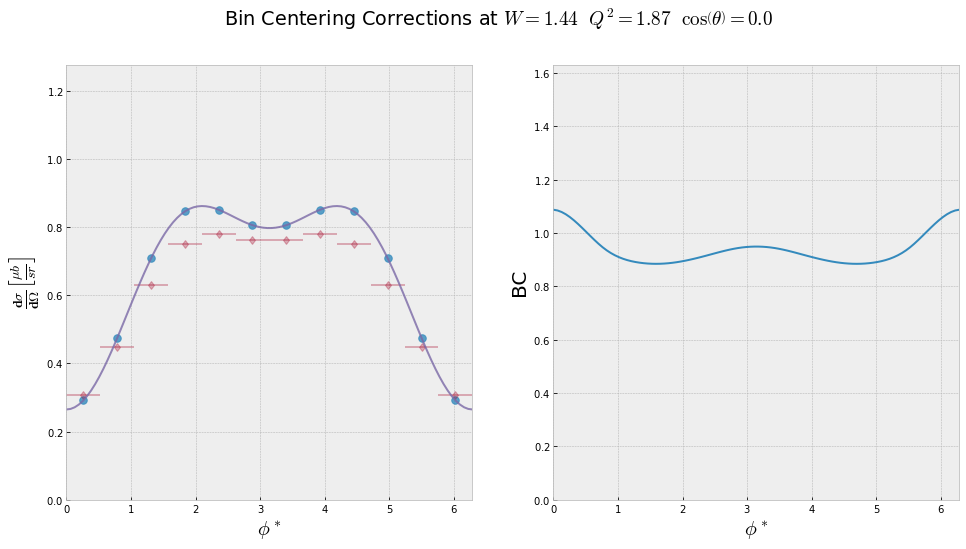

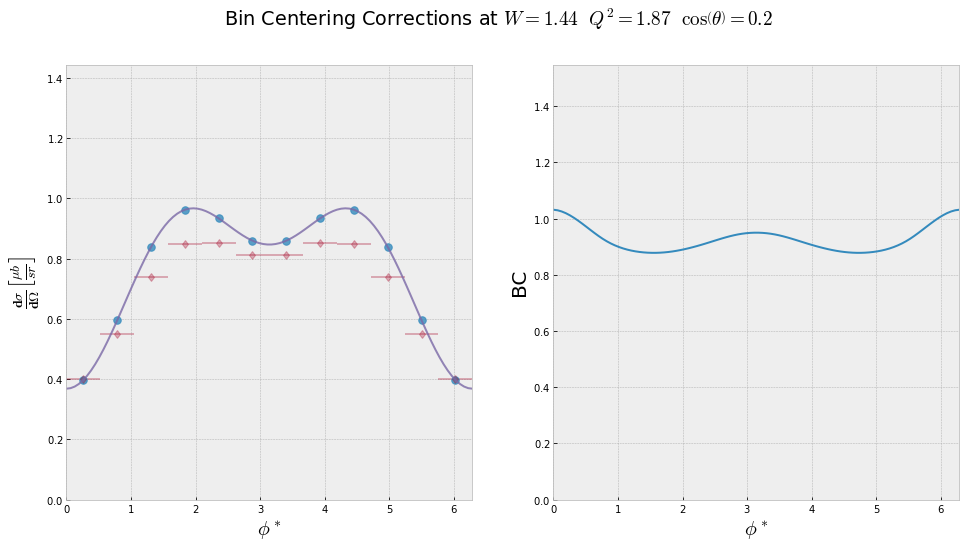

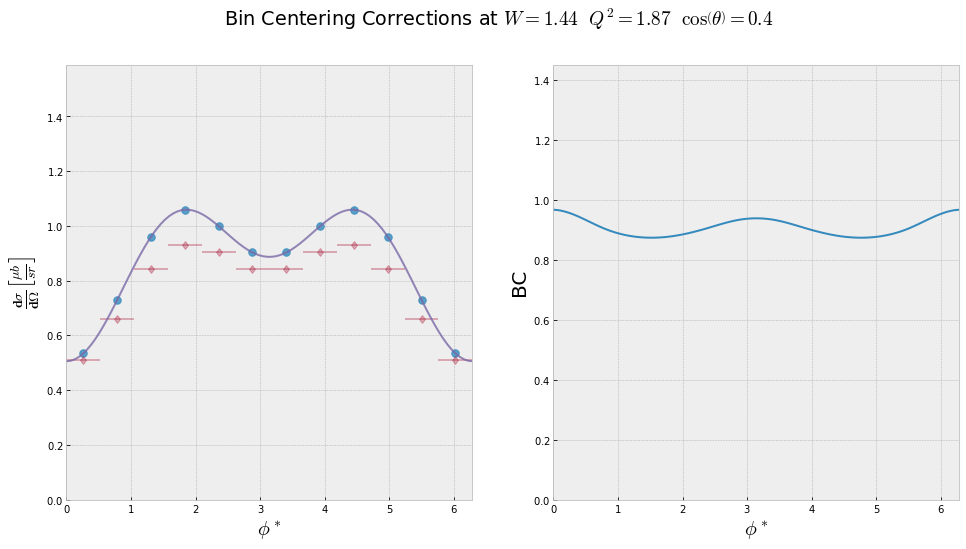

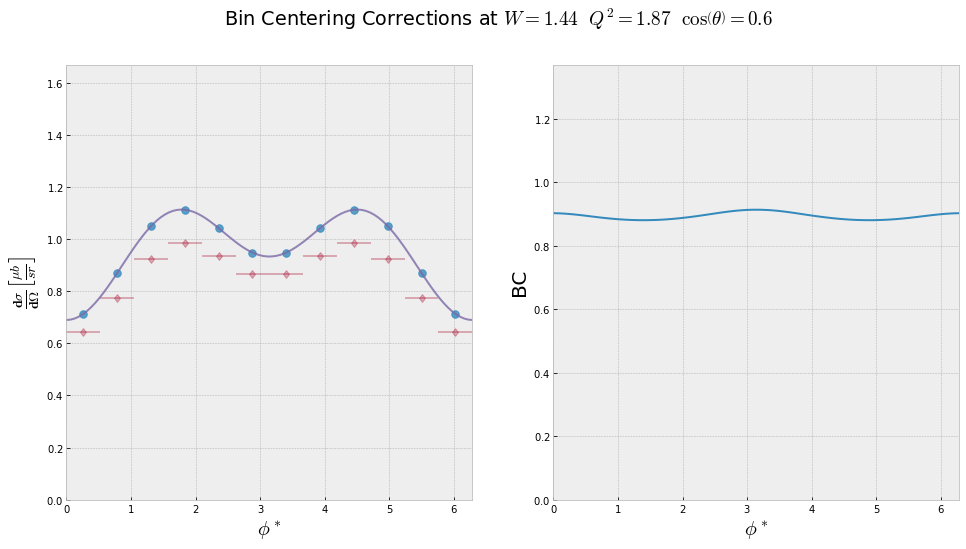

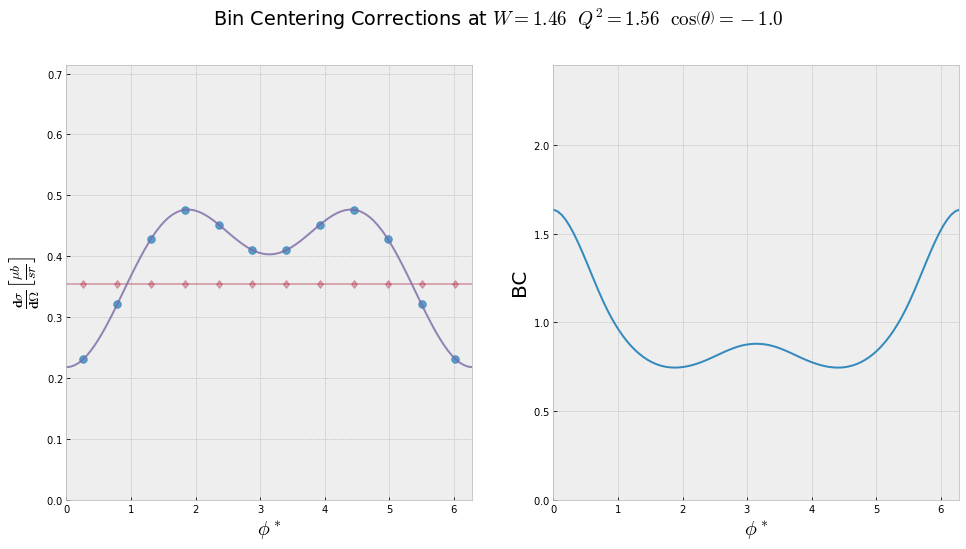

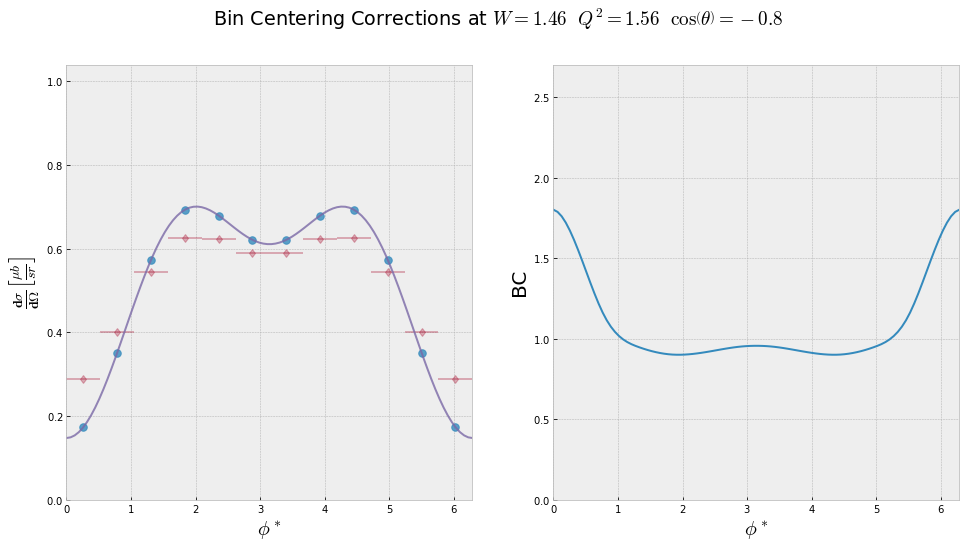

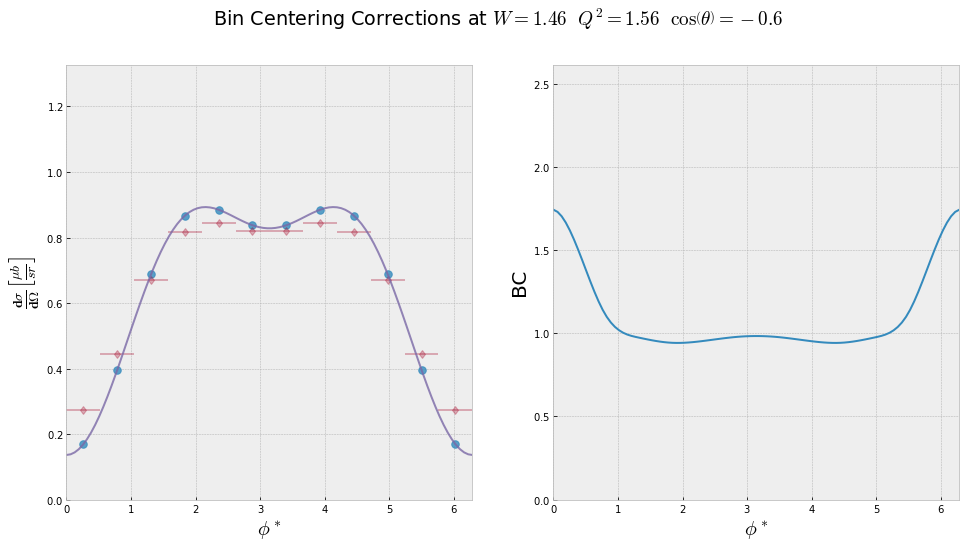

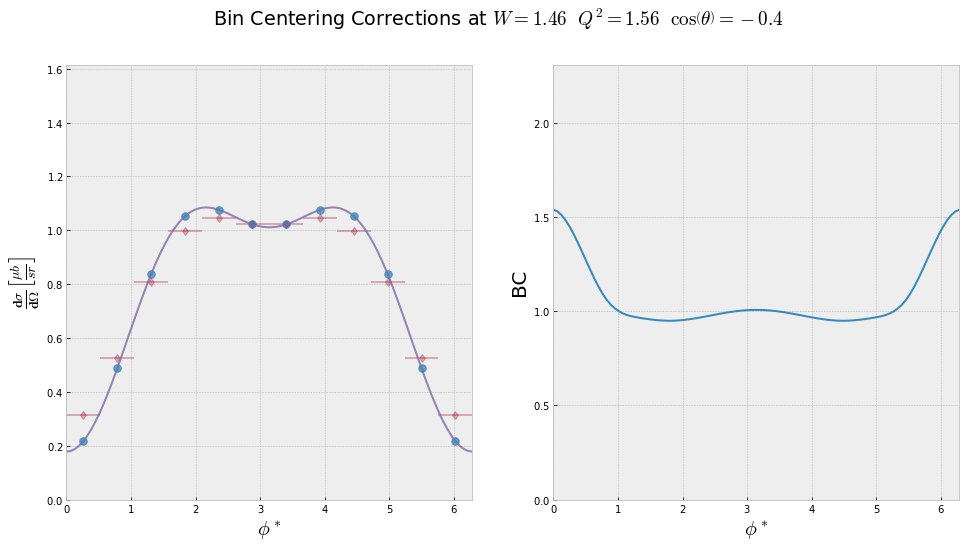

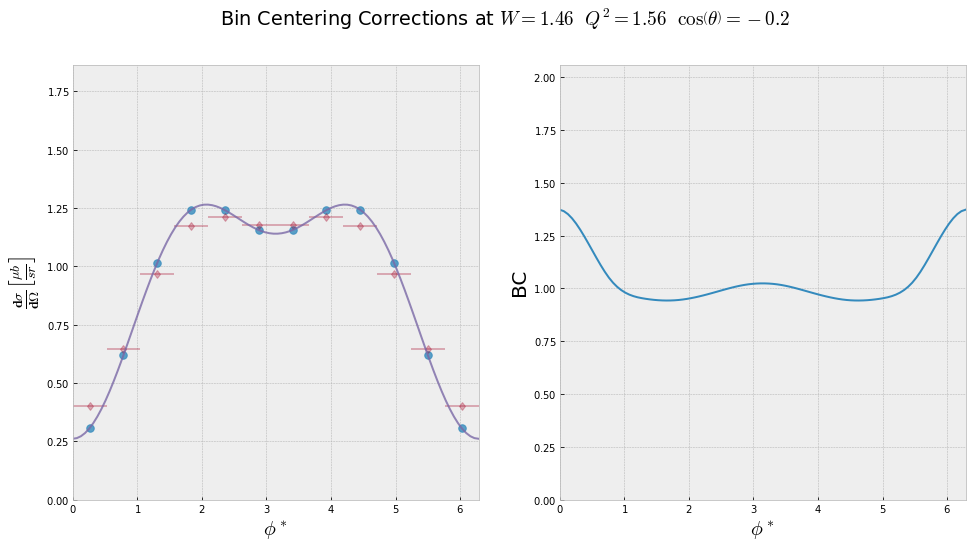

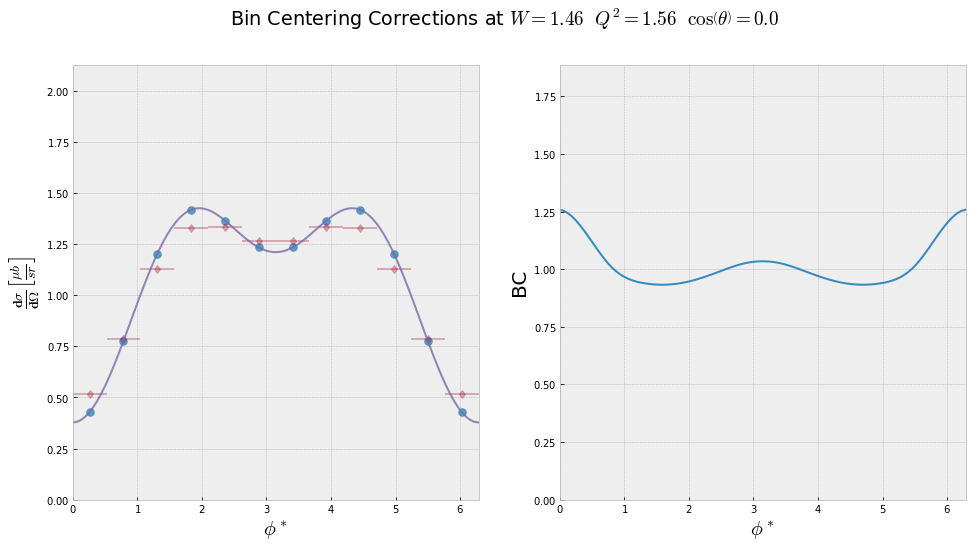

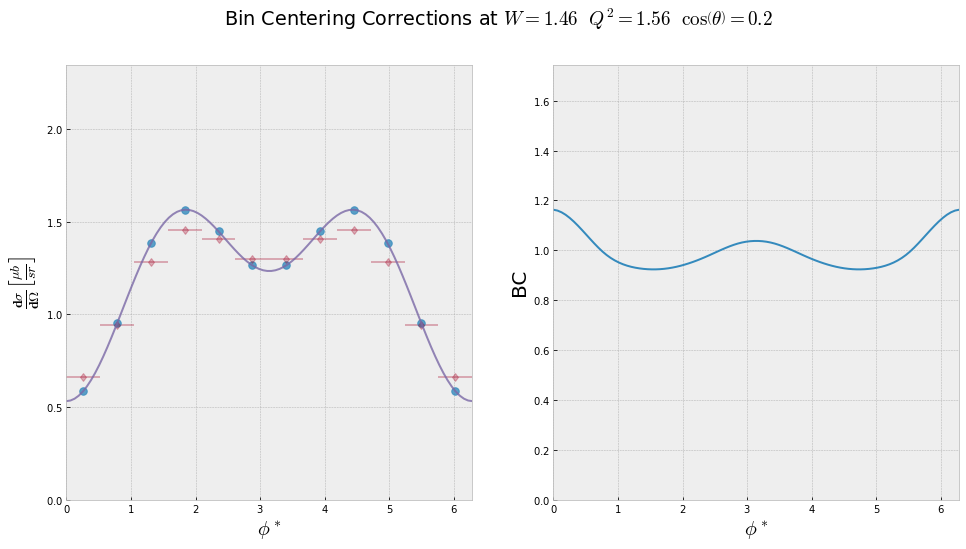

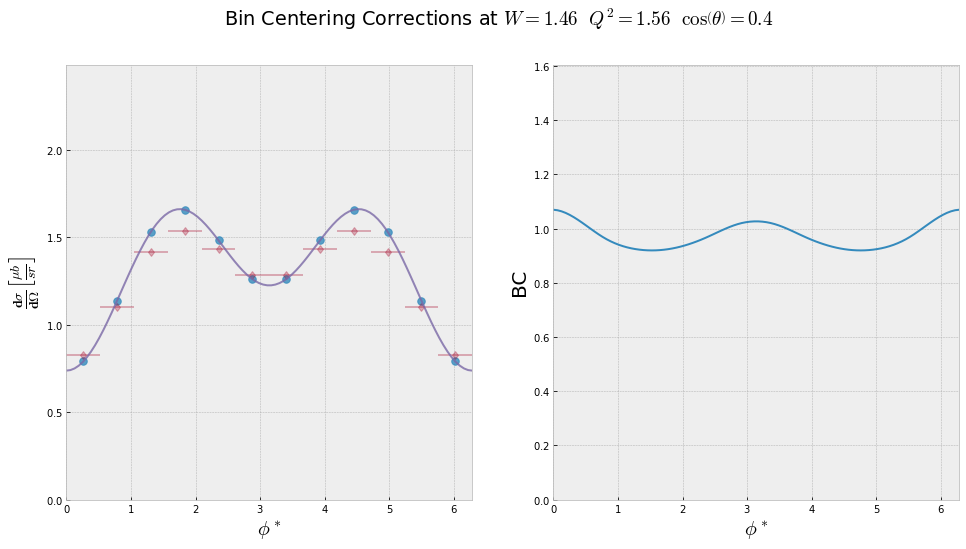

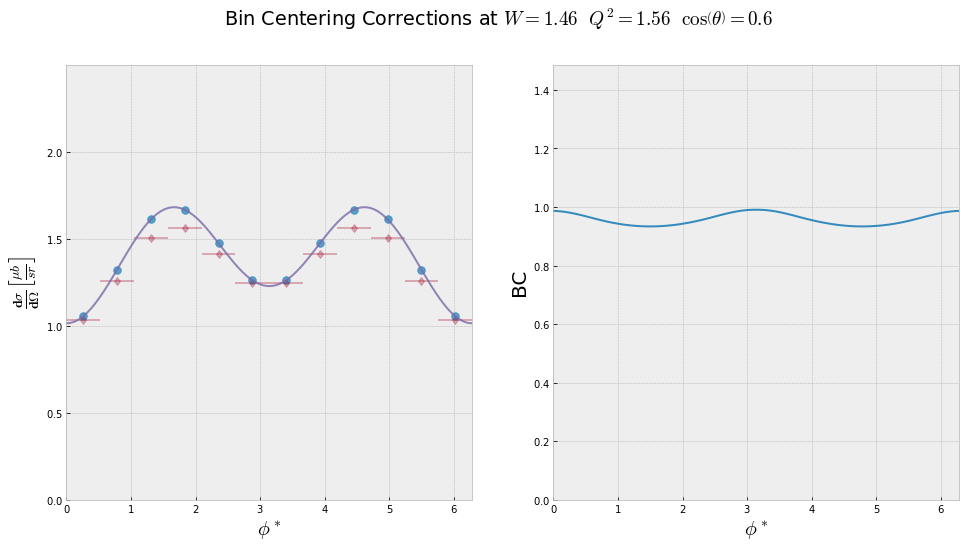

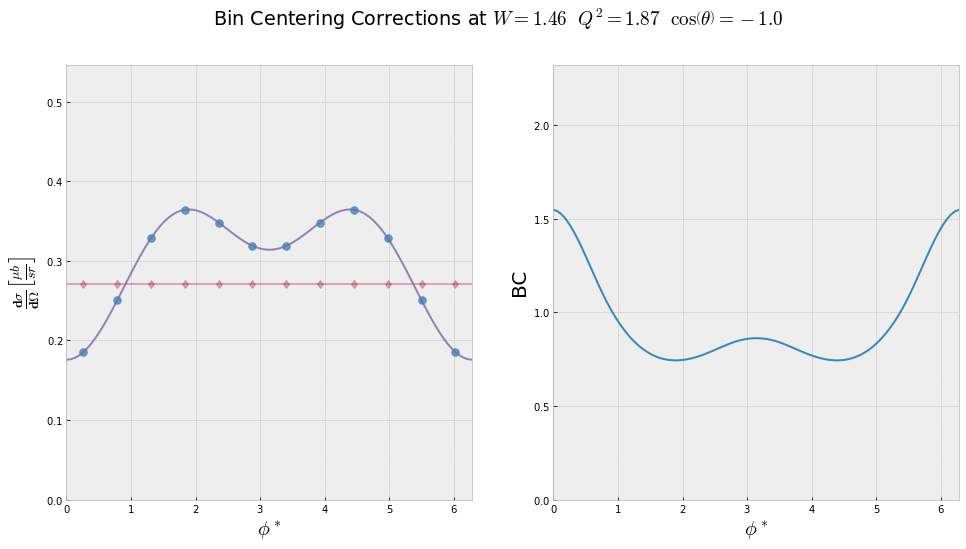

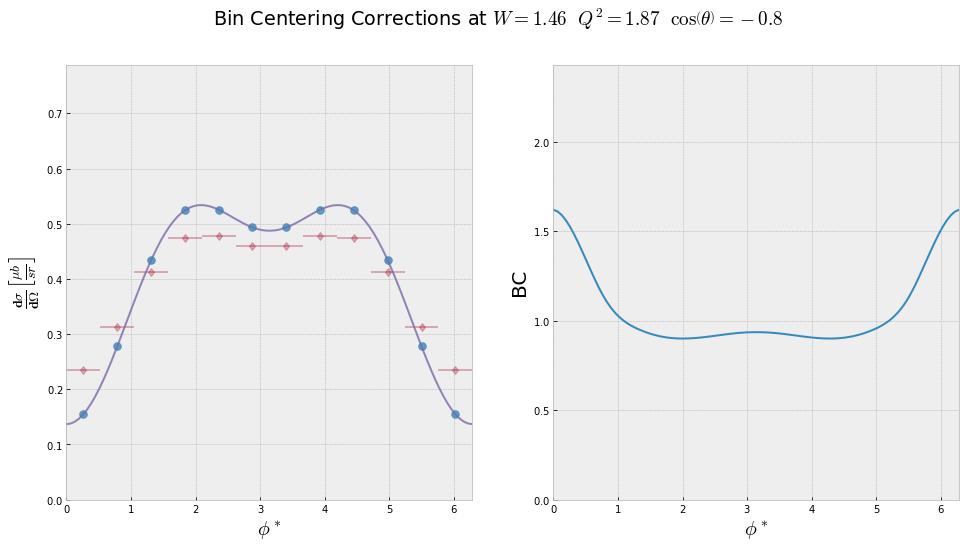

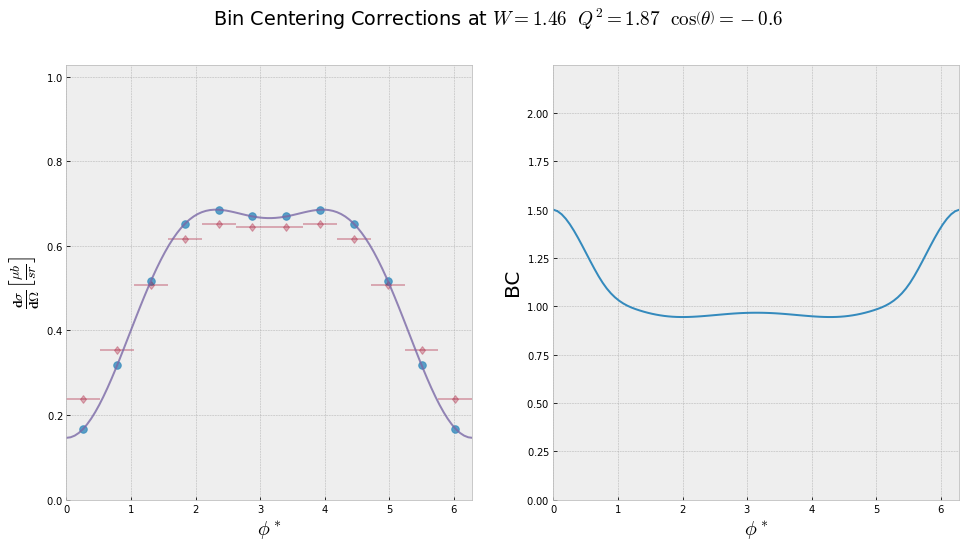

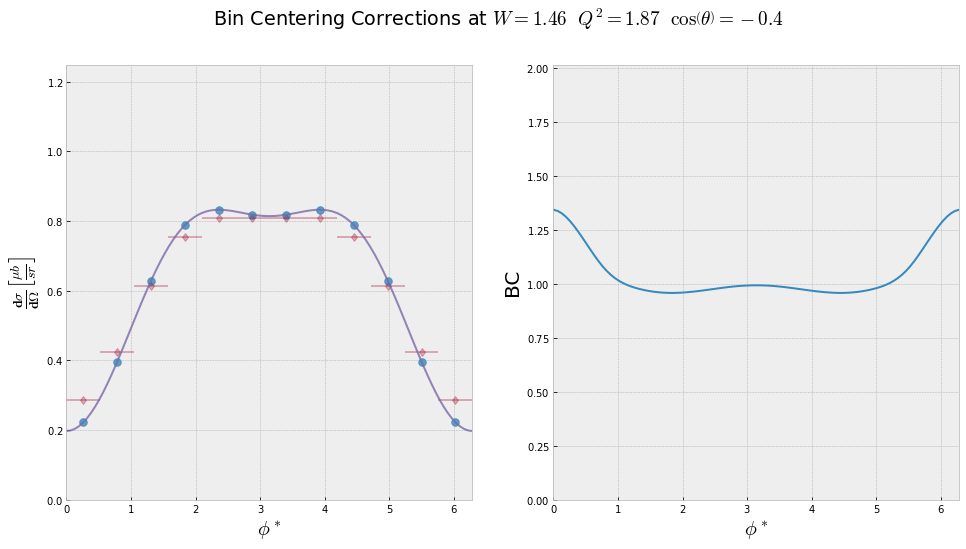

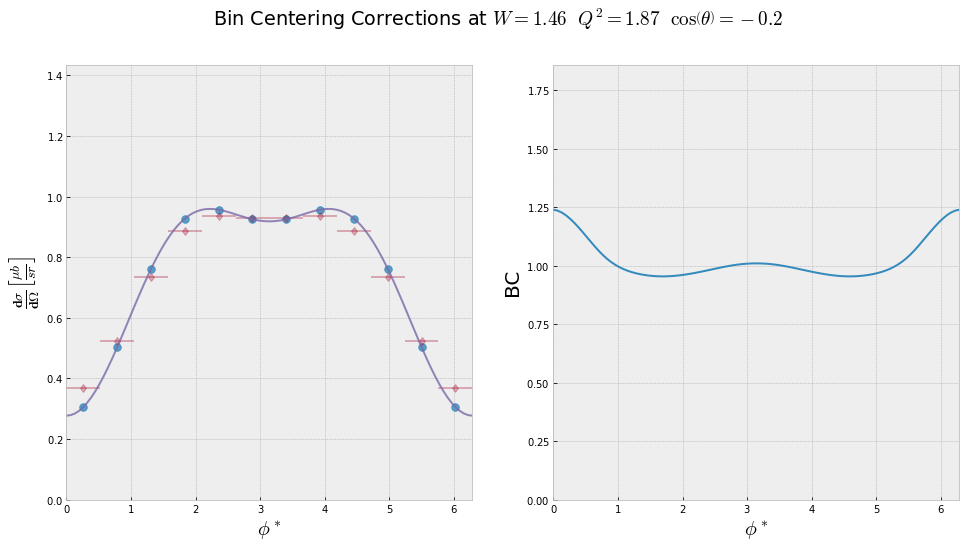

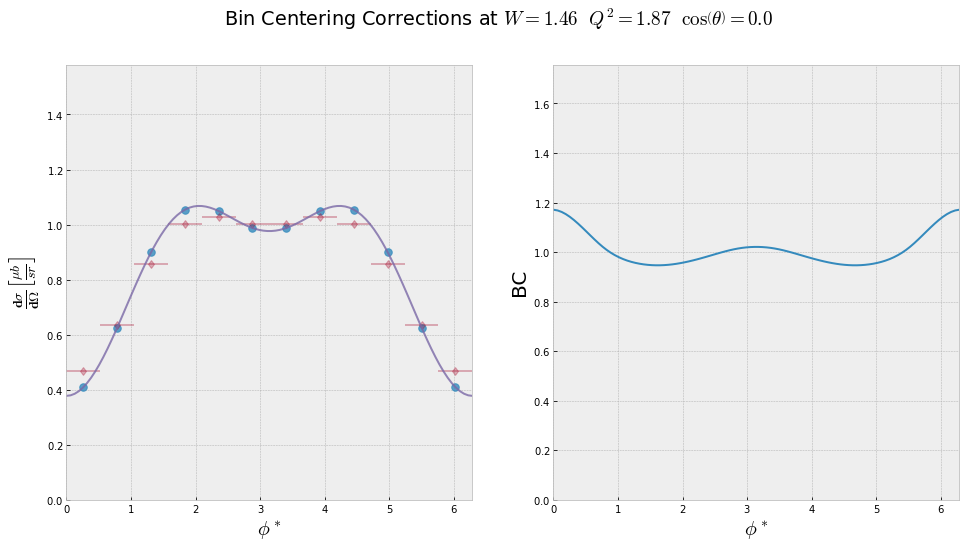

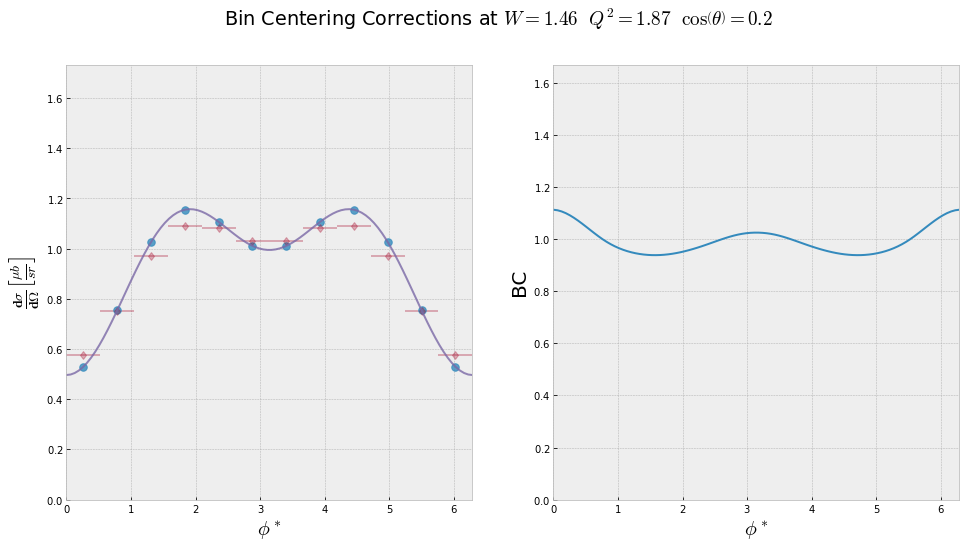

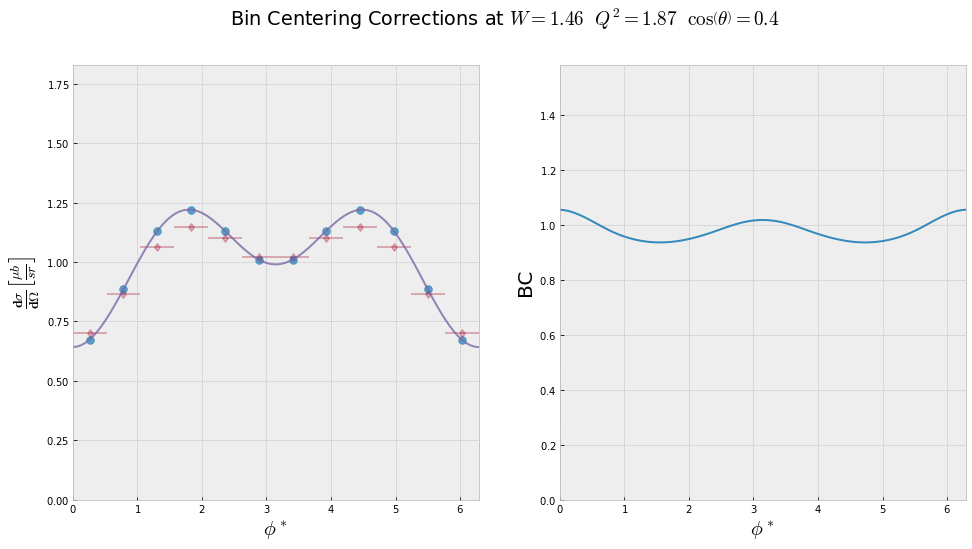

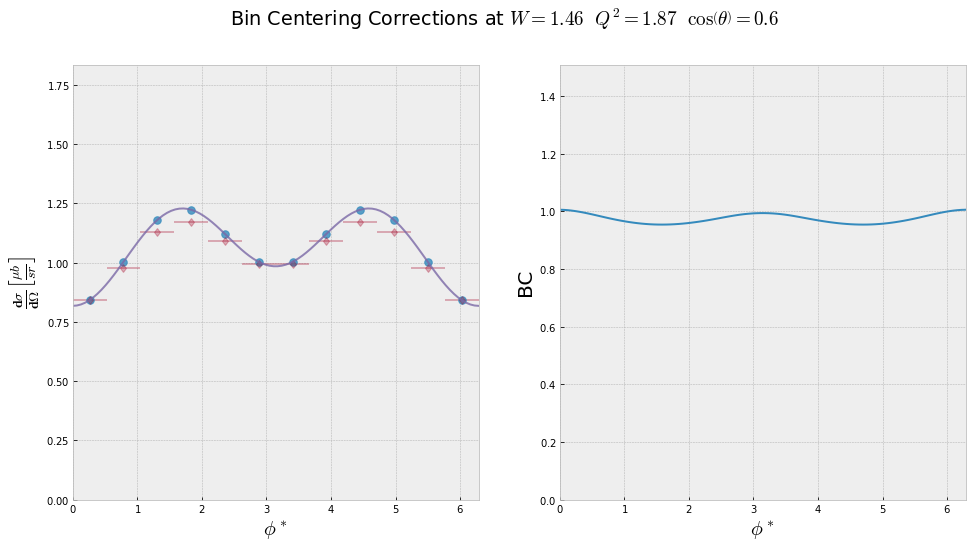

In [7]:
for w in [1.44, 1.46]:
    for q2 in [1.56, 1.87]:
        for theta in theta_bins[:-1]:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=[16,8], sharex=True)
            num_bins = 12
            width = np.linspace(0,  2*np.pi, num_bins+1, endpoint=True)[1]
            left = np.array([i*width for i in range(num_bins+2)])
            right = np.array([(i-1)*width for i in range(num_bins+2)])
            
            center = (left+right)/2.0
            
            _xs = {'.' : left, 'x': right, 'd': center}
            
            ys = []
            
            ys.append(get_maid_values(left, w, q2, theta))
            ys.append(get_maid_values(right, w, q2, theta))
            
            ys.append(get_maid_values(left, w+0.02, q2, theta))
            ys.append(get_maid_values(right, w+0.02, q2, theta))
            
            ys.append(get_maid_values(left, w, q2+0.36, theta))
            ys.append(get_maid_values(right, w, q2+0.36, theta))
            
            ys.append(get_maid_values(left, w+0.02, q2+0.36, theta))
            ys.append(get_maid_values(right, w+0.02, q2+0.36, theta))
            
            ys.append(plot_maid_model(ax[0], w, q2, theta+0.1, center, '.'))

            
            avg = (ys[0]+ys[1]+ys[2]+ys[3]+ys[4]+ys[5]+ys[6]+ys[7])/8
            ax[0].errorbar(center, avg, fmt='d', alpha=0.3, label='center', xerr=width/2)
            
            #ax[1].errorbar(center, avg/ys[2], fmt='.')

            bin_center_corr = interp1d(center, avg/ys[-1], kind='cubic')

            z = np.linspace(0, 2*np.pi, 100)
            ax[1].plot(z, bin_center_corr(z))

            plot_maid_model(ax[0], w, q2, theta+0.1, z, fmt='-')
            # ax[1].errorbar(z, corr(z), fmt='d', yerr=bin_center_corr(z)-corr(z))
            
            plt.suptitle(f"Bin Centering Corrections at $W = {w}~~Q^2 = {q2}~~\cos\left(\\theta\\right) = {theta}$")
            ax[0].set_xlim(0,2*np.pi)
            try:
                ax[1].set_ylim(0, 1.5*np.max(bin_center_corr(z)))
            except ValueError:
                pass
            
            try:
                ax[0].set_ylim(0,1.5*np.max(ys[-1]))
            except ValueError:
                pass
            ax[0].set_ylabel(r'$\frac{\mathbf{d}\sigma}{\mathbf{d} \Omega} \left[\frac{\mu b}{sr}\right]$')
            ax[1].set_ylabel('BC')
            ax[0].set_xlabel(r'$\phi^*$')
            ax[1].set_xlabel(r'$\phi^*$')
            
            
            plt.show()

In [5]:
# for w in w_bins[:1]:
#     for q2 in q2_bins[:1]:
#         for theta in theta_bins[4:5]:
#             fig, ax = plt.subplots(nrows=1, ncols=1)
#             xs = np.linspace(0, 2*np.pi, 200)
#             y = plot_maid_model(ax, w, q2, theta, xs, 'd')
#             # y = plot_maid_model_old(ax[0], w, q2, theta, xs, '.')
#             # y = plot_maid_model_old(ax[1], w, q2, theta, xs, '.')

#             # ax[1].errorbar(z, corr(z), fmt='d', yerr=bin_center_corr(z)-corr(z))
            
#             plt.title(f"$W$ = {w} $Q^2$ = {q2} $\\theta$ = {theta}")
            
#             ax.set_ylim(0, np.max(y)*1.5)
            
#             plt.show()